<a href="https://colab.research.google.com/github/Bati-bot/TPAA2/blob/master/TP2_AA_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Descargamos los datos
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speechcommands
!tar -xf speech_commands_v0.01.tar.gz -C /content/speechcommands

--2020-07-12 17:11:12--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.126.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz.1’

speech_commands_v0. 100%[===================>]   1.39G   190MB/s    in 7.8s    

2020-07-12 17:11:20 (182 MB/s) - ‘speech_commands_v0.01.tar.gz.1’ saved [1489096277/1489096277]

mkdir: cannot create directory ‘speechcommands’: File exists


In [4]:
#Importamos librerías
import librosa
import glob
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns


import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
#Lo cargamos una vez generado
df = pd.read_csv('numbers.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df['target'] = df['target'].str.split('\\', expand=True)[0]

In [6]:
#Importamos los listados de validation y test
testing_list = pd.read_csv('speechcommands/testing_list.txt', sep=' ', 
                           names=['file_test'])
validation_list = pd.read_csv('speechcommands/validation_list.txt', sep=' ', 
                              names=['file_val'])

In [7]:
# Cambiamos el formato para que quede igual que en el df
testing_list['file_test'] = testing_list['file_test'].str.replace('/', '\\')
validation_list['file_val'] = validation_list['file_val'].str.replace('/', '\\')

In [8]:
#Creamos una columna con el set. Ponemos 'train' por default
df['set'] = 'train'

In [9]:
#Hacemos un merge para identificar los registros de test
df = df.merge(testing_list, left_on='file', right_on='file_test', how='left', suffixes=('', '_y'))
df['set'][df['file_test'].notna()] = 'test'
df.drop(columns='file_test', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#Idem para registros de validación
df = df.merge(validation_list, left_on='file', right_on='file_val', how='left', suffixes=('', '_y'))
df['set'][df['file_val'].notna()] = 'validation'
df.drop(columns='file_val', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#Separamos los datasets
train = df[df['set']=='train']
validation = df[df['set']=='validation']
test = df[df['set']=='test']

In [12]:
train = df[df['set']!='test']
test = df[df['set']=='test']

In [13]:
my_test_fold = np.where(train['set']=='validation', 0,-1)
ps = PredefinedSplit(test_fold=my_test_fold)

In [14]:
X_train = train.drop(columns=['set', 'file', 'target'])
y_train = train['target']
X_test = test.drop(columns=['set', 'file', 'target'])
y_test = test['target']

### Opcional (da puntos extra): implementar un modelo de perceptrón multicapa. Elegir el número de neuronas de la capa oculta utilizando random search. Comparar su rendimiento con los demás modelos desarrollados en c)



In [15]:
# Imports
import keras
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input    #for Dense layers
from keras.layers import BatchNormalization #for batch normalization
from keras.layers import Dropout            #for random dropout
from keras.models import Sequential #for sequential implementation
from keras.optimizers import Adam   #for adam optimizer
from keras import regularizers 

In [16]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

In [17]:
# Preparamos el formato del output para una NN
y_train_MLP = y_train.copy()
y_test_MLP = y_test.copy()
y_train_MLP.replace({'zero':0, 'one':1, 'two':2 ,'three':3 ,'four':4 ,
                     'five':5, 'six': 6,'seven':7 ,'eight':8,'nine':9}, 
                    inplace=True)
y_test_MLP.replace({'zero':0, 'one':1, 'two':2 ,'three':3 ,'four':4 ,
                     'five':5, 'six': 6,'seven':7 ,'eight':8,'nine':9}, 
                    inplace=True)

In [18]:
# Convertimos target a categorica
num_classes = 10
y_train_MLP = to_categorical(y_train_MLP, num_classes)
y_test_MLP = to_categorical(y_test_MLP, num_classes)

In [19]:
# Covertimos X a numpy array
X_train_MLP = X_train.to_numpy()
X_test_MLP = X_test.to_numpy()

In [20]:
  # Create the model
def create_model():
    input_shape = X_train_MLP[0].shape

    model = Sequential()
    model.add(Dense(350, input_shape=input_shape, activation='relu'))

    #model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
# Creamos el modelo
def create_model():
    layer_in = tfkl.Input(shape=X_train_MLP[0].shape) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones
    #Esta capa rompe la estructura de imagen y nos deja un vector (1x784)
    flatten_layer = tfkl.Flatten()(layer_in)
    #Esta es la capa de salida
    hidden_layer = tfkl.Dense(units=128, activation='relu')(flatten_layer)
    #Esta es la capa de salida:
    output_layer = tfkl.Dense(units=10,activation='softmax')(hidden_layer) 

    # Definimos optimizador y metricas
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compilamos el modelo
    model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model

In [22]:
# Lo metemos en un objeto KerasClassifier para poder usar RandomizedSearchCV de
# Sklearn
model_keras = KerasClassifier(build_fn=create_model, verbose=1)

In [23]:
# Vemos el resumen
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 78)]              0         
_________________________________________________________________
flatten (Flatten)            (None, 78)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               10112     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 11,402
Trainable params: 11,402
Non-trainable params: 0
_________________________________________________________________


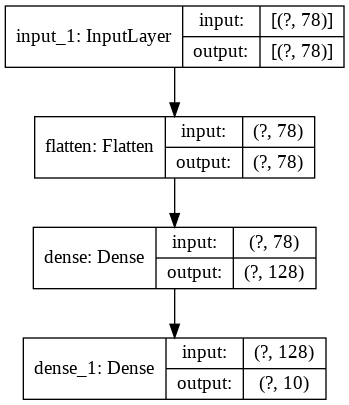

In [24]:
# Lo ploteamos
tf.keras.utils.plot_model(model,show_shapes=True)

In [25]:
# Definimos espacio de hiperparametros
params = {'epochs':range(10, 200, 10), 
            'batch_size':range(10, 100, 5)}

In [ ]:
# Y hacemos una búsqueda sobre el mismo
rs = RandomizedSearchCV(model_keras, params, n_iter = 20, verbose= 10, 
                          n_jobs=-1, cv=ps, random_state=42)
print (rs)
fit = rs.fit(X_train_MLP, y_train_MLP)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f144aa9b6d8>,
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': range(10, 100, 5),
                                        'epochs': range(10, 200, 10)},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=10)
Fitting 1 folds for each of 20 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.4min


In [ ]:
# Imprimimos los resultados
best_model = fit.best_estimator_.model
test_results = best_model.evaluate(X_test_MLP, y_test_MLP, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

In [ ]:
# vemos los parametros
fit.best_params_

Conclusión: Obtenemos un resultado similar al mejor obtenido con GB con una red bastante simple, lo que indicaría que podrían mejorarse aún más estos resultados.